In [1]:
# Set Directories

MAIN_DIR = "/gws/nopw/j04/ai4er/users/trr26/earthquake-predictability"
DATA_DIR = "/gws/nopw/j04/ai4er/users/trr26/earthquake-predictability/data/gtc_quakes_data"
p4581_FILE_PATH = f"{DATA_DIR}/labquakes/Marone/p4581/p4581.txt"

# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from math import sqrt
from scipy.io import loadmat
import scipy
import ipywidgets as widgets
from IPython.display import display

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 
from tqdm.auto import tqdm
import random
import os

import sys
sys.path.append(MAIN_DIR)
import utils

In [2]:
with open(p4581_FILE_PATH, "r") as file:
    df = pd.read_csv(file, delim_whitespace=True, skiprows=4)

df.columns = [
    "id",
    "lp_disp",
    "shr_stress",
    "nor_disp",
    "nor_stress",
    "time",
    "sync",
    "samp_freq",
]

df = df.drop(["id"], axis=1)
df = df[['time'] + [col for col in df.columns if col != 'time']]

df.head()

,time,lp_disp,shr_stress,nor_disp,nor_stress,sync,samp_freq
0,1.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
1,2.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
2,3.0,0.0,0.0,-0.0,1.000000e-18,3.29853,1
3,4.0,0.0,0.0,-0.0,1.000000e-18,3.29854,1
4,5.0,0.0,0.0,-0.0,1.000000e-18,3.29855,1


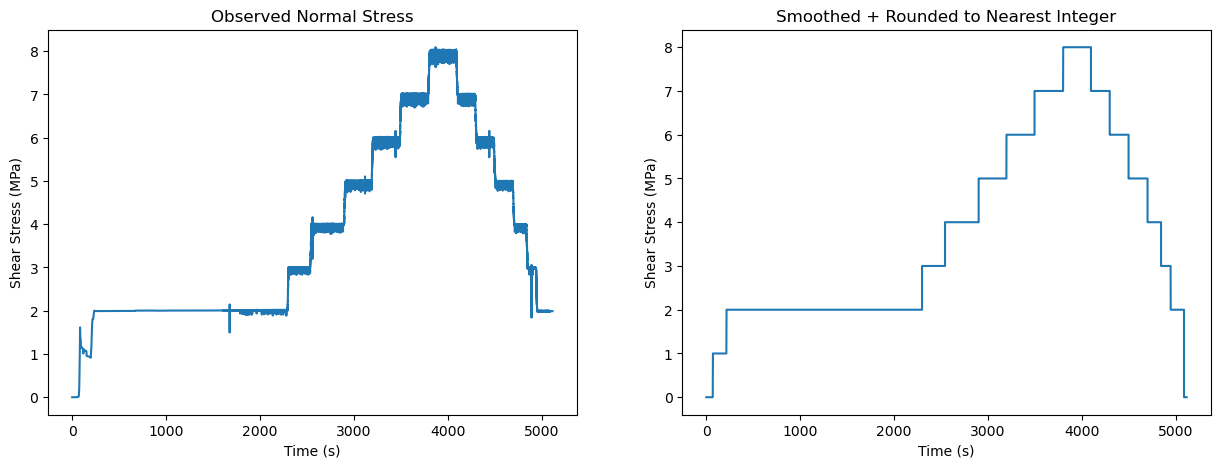

In [37]:
window_size = 100
df['smoothed_nor_stress'] = df['nor_stress'].rolling(window_size, center=True).mean()
df['target_nor_stress'] = df['smoothed_nor_stress'].fillna(0).round().astype(int)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1
axes[0].plot(df["time"], df["nor_stress"])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Shear Stress (MPa)')
axes[0].set_title("Observed Normal Stress")

# Plot 2
axes[1].plot(df["time"], df["target_nor_stress"])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Shear Stress (MPa)')
axes[1].set_title("Smoothed + Rounded to Nearest Integer")

plt.show()

In [25]:
# Find the indices where target_nor_stress changes
segment_indices = np.where(df['target_nor_stress'].diff() != 0)[0]

# Segment the dataframe based on the indices
segments = np.split(df, segment_indices)


/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [30]:
# Create a dropdown widget with segment indices as options
segment_dropdown = widgets.Dropdown(
    options=list(range(len(segments))),
    description='Segment:',
    value=0,
)

def update_plot(segment_index):
    num_columns = len(segments[segment_index].columns) - 1  # Exclude the 'time' column
    num_rows = (num_columns + 1) // 2  # Calculate the number of rows for subplots

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))  # Adjust the figsize here

    for i, column in enumerate(segments[segment_index].columns[1:]):  # Exclude the 'time' column
        row = i // 2
        col = i % 2
        ax = axes[row, col] if num_rows > 1 else axes[col]

        ax.plot(segments[segment_index]["time"], segments[segment_index][column])
        ax.set_xlabel('Time (s)')
        ax.set_title(column)

    plt.tight_layout()
    plt.show()


# Display the dropdown widget and plot
widgets.interact(update_plot, segment_index=segment_dropdown)


interactive(children=(Dropdown(description='Segment:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

<function __main__.update_plot(segment_index)>

In [26]:
def detrend_first_order_poly(x, y):
    p = np.polyfit(x, y, deg=1)
    y_det = y - (p[0] * x + p[1])
    return y_det

In [34]:
segment_dropdown = widgets.Dropdown(
    options=list(range(len(segments))),
    description='Segment:',
    value=4,
)

def update_plot(segment_index):
    x = segments[segment_index]["time"]
    y = segments[segment_index]["shr_stress"]
    y_det = detrend_first_order_poly(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(x, y)
    axes[0].set_title("Observed")
    axes[1].plot(x, y_det)
    axes[1].set_title("Detrended")
    plt.show()

widgets.interact(update_plot, segment_index=segment_dropdown)


interactive(children=(Dropdown(description='Segment:', index=4, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,…

<function __main__.update_plot(segment_index)>